## Trace regression on SPD manifold

We consider the regularization-free trace regression model [1] for estimating covariance and kernel matrices. We follow the set up in [2].



Reference:

[1] Slawski, M., Li, P., & Hein, M. (2015). Regularization-free estimation in trace regression with symmetric positive semidefinite matrices. *Advances in Neural Information Processing Systems*, 28.

[2] Han, A., Mishra, B., Jawanpuria, P. K., & Gao, J. (2021). On Riemannian optimization over positive definite matrices with the Bures-Wasserstein geometry. *Advances in Neural Information Processing Systems*, 34.

The problem of concern is 
$$\min_{\mathbf X \in \mathbb S^d_{++}} \frac{1}{n} \sum_{i=1}^n  (y_i - \text{tr}(\mathbf A_i^\top \mathbf X))^2$$
where $\mathbf A_i = \mathbf a_i \mathbf a_i^\top$ are some rank-one measurement
matrices.

In [1]:
#!pip install git+https://github.com/SaitejaUtpala/rieoptax.git
!pip install git+https://github.com/andyjm3/rieoptax.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andyjm3/rieoptax.git to /tmp/pip-req-build-tkmjvwd2
  Running command git clone --filter=blob:none --quiet https://github.com/andyjm3/rieoptax.git /tmp/pip-req-build-tkmjvwd2
  Resolved https://github.com/andyjm3/rieoptax.git to commit 7517e2f302f7378980f71497a978f83fffea6c82
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 KB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
seed = 42

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

from timeit import default_timer as timer

from jax.config import config
from jax import jit, vmap
from jax import numpy as jnp
from jax.numpy.linalg import qr, slogdet
from jax.numpy.linalg import norm
from jax import random

config.update("jax_enable_x64", True) # run jax at float64 bit precision

from rieoptax.core import ManifoldArray, rgrad
from rieoptax.geometry.spd import SPDAffineInvariant, SPDBuresWasserstein
from rieoptax.optimizers.first_order import rsgd
from rieoptax.optimizers.update import apply_updates

Generate data

In [7]:
myeps = 1e-2
n = 1000
m = 50
r = m

key = random.PRNGKey(seed)        
x = random.normal(key, shape=(n,m))
y = jnp.zeros(shape=(n,))

key = random.PRNGKey(seed)
Sigmaorg = random.normal(key, shape=(m,r))
Sigmaorg = Sigmaorg @ Sigmaorg.T/m 

y = []
for i in range(n):
    key = random.PRNGKey(seed)      
    y.append(x[i:i+1,:] @  Sigmaorg @ x[i:i+1,:].T + myeps*random.normal(key, shape=(1,)))

y = jnp.concatenate(y, axis=0)

In [8]:
costopt = 0
for i in range(n):
  costopt += (y[i] - x[i:i+1,:] @  Sigmaorg @ x[i:i+1,:].T)**2 
costopt = costopt/n

In [9]:
costopt = costopt.item()
print(costopt)

0.0004708138622905273


In [10]:
# Xinit
Xinit = jnp.eye(m)

# define fit function
def fit(params, data, y, optimizer, epochs):
    @jit 
    def step(params, opt_state, data, y):

        def cost(params, data, y):
            def _cost(params, data, y):
                return (y - data @  params.value @ data.T)**2
            return vmap(_cost, in_axes=(None,0, 0))(params, data, y).mean()

        rgrads = rgrad(cost)(params, data, y) #calculates Riemannian gradients
        updates, opt_state = optimizer.update(rgrads, opt_state, params)
        params = apply_updates(params, updates) #Update using Riemannian Exp
        loss_value = cost(params, data, y)
        return params, opt_state, loss_value

    opt_state = optimizer.init(params)
    rieoptax_loss = []
    rieoptax_time = []
    start = timer()
    for i in range(epochs):
        params, opt_state, loss_value = step(params, opt_state, data, y)
        #print(f"iter {i}:", loss_value)
        elapsed_time = timer() - start
        rieoptax_loss.append(loss_value)
        rieoptax_time.append(elapsed_time)


    return rieoptax_loss, rieoptax_time

Comparing BW and AI geometries

We notice Bures-Wasserstein geometry is better suited for this problem than Affine-Invariant geometry. In the stochastic setting, even with very small learning rate, the iterates diverge with AI geometry. This is aligned with the analysis and findings in [2]. The primary reason being BW geometry is better-conditioned for this problem.

In [35]:
X_init = ManifoldArray(value=Xinit, manifold=SPDAffineInvariant(m))    
epochs = 500
lr = 1e-7
optimizer = rsgd(lr)
rieoptax_loss_AI, rieoptax_time_AI = fit(X_init, x, y, optimizer, epochs)

In [37]:
# BW
X_init = ManifoldArray(value=Xinit, manifold=SPDBuresWasserstein(m))    
epochs = 500
lr = 2e-3
optimizer = rsgd(lr)
rieoptax_loss_BW, rieoptax_time_BW = fit(X_init, x, y, optimizer, epochs)

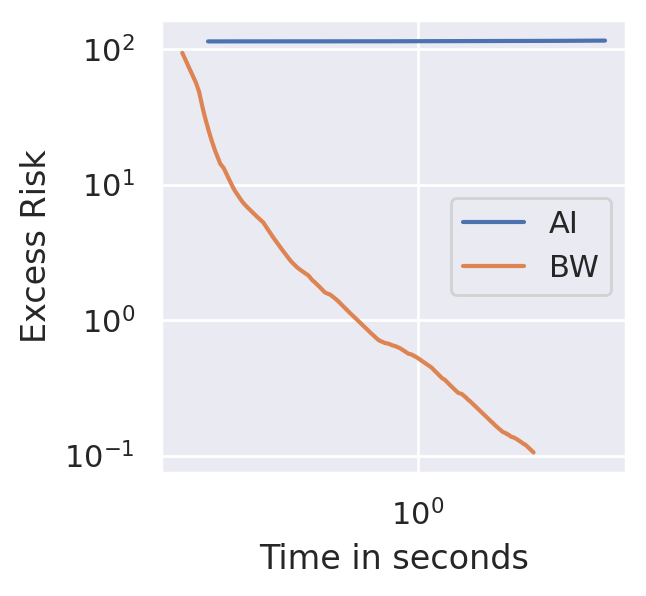

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
sns.set_style("darkgrid")


fig, axes = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
axes.plot(jnp.asarray(rieoptax_time_AI),  jnp.asarray(rieoptax_loss_AI) - jnp.asarray(costopt), label='AI')
axes.plot(jnp.asarray(rieoptax_time_BW),  jnp.asarray(rieoptax_loss_BW) - jnp.asarray(costopt), label='BW')
axes.legend(loc='center right')
axes.set_yscale("log")
axes.set_xscale("log")
axes.set_ylabel("Excess Risk")
axes.set_xlabel("Time in seconds")
plt.show()